# Kaggle Ghosts competition

In [ ]:
import pandas as pd
import numpy as np
import re
from itertools import compress
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import ensemble

# Kaggle Ghosts - Python version

Read the train and test datasets

In [2]:
# For .read_csv, always use header=0 when you know row 0 is the header row
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

## Exploring data

Usins th `sns` library, let's explore the train dataset and see how the creatures are distributed:

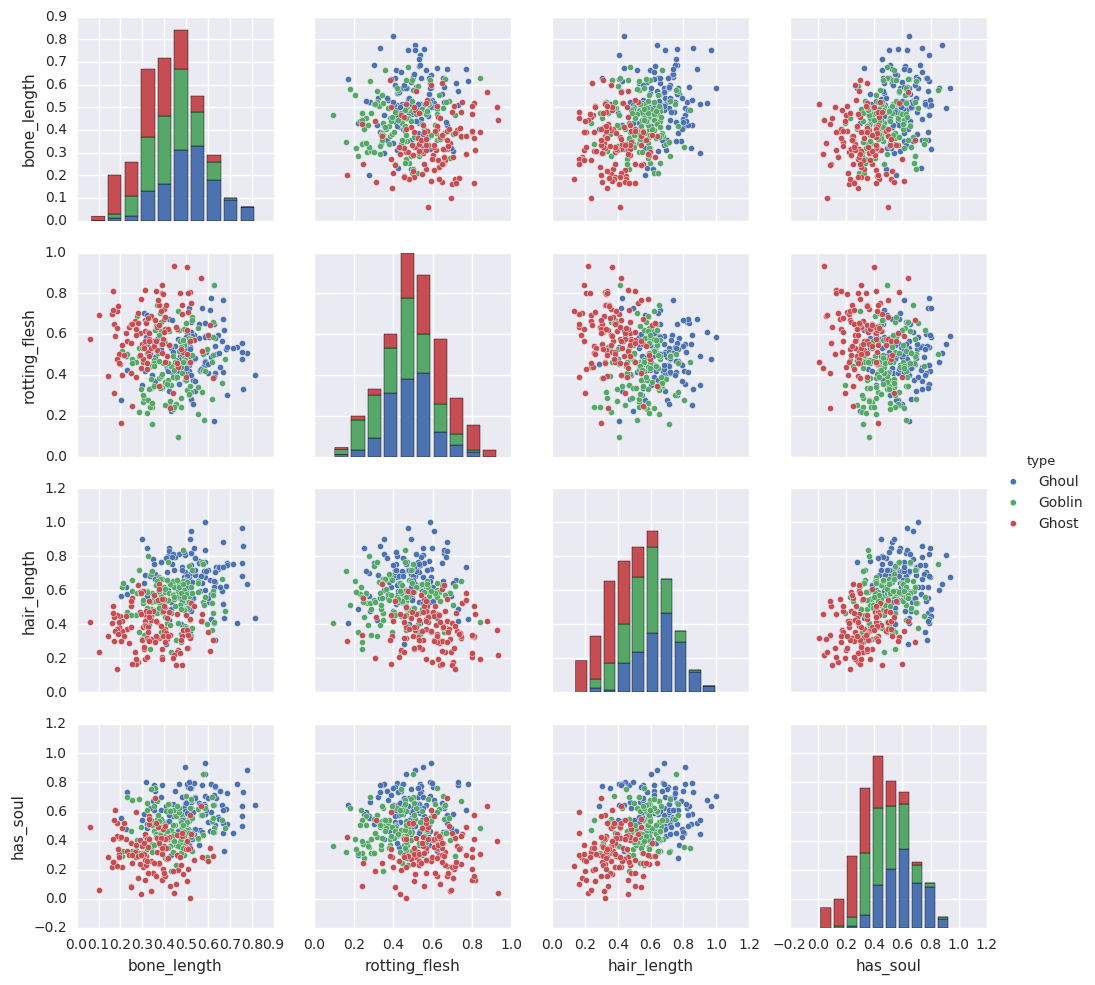

In [3]:
sns.set()

# We don't want to show the ID col
sns.pairplot(train.ix[:,1:],hue="type")

As we can see _Ghouls_ are in one side, _Ghosts_ on the other side and _Goblins_ in between them.

## Prediction

I'll use several predictions techiniques to try to find the anwser, and them compare the results.

### Random Forrest

The first attempt will be random forrest.

In [4]:
trainData = pd.get_dummies(train.ix[:,1:6])
targetData = train['type']

testData = pd.get_dummies(test.ix[:,1:])
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(trainData, targetData)

# Predict the values
outputRandomForrest = forest.predict(testData)

### SVM

The second attempt will be SVM using the Linear kernel.

In [5]:
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(trainData,targetData)

outputSVMLinear = clf.predict(testData)

### Decision Tree Classifier

The next attempt will use decisions trees.

In [6]:
treeC = tree.DecisionTreeClassifier();

treeC.fit(trainData, targetData)

outputDecisionTree = treeC.predict(testData)

### K Neighbors


In [7]:
nC = neighbors.KNeighborsClassifier(n_neighbors=4)

nC.fit(trainData, targetData)

outputNeighbors = nC.predict(testData)

### Linear Model - SGD Classifier

Attempt with the Linear Model SGD Classifier.

In [8]:
lmC = linear_model.SGDClassifier()

lmC.fit(trainData, targetData)

outputLM = lmC.predict(testData)


### Gaussian Naive Bayes

Attempt with Gaussian Naive Bayes

In [9]:
gnbC = naive_bayes.GaussianNB()
gnbC.fit(trainData, targetData)

outputGNB = gnbC .predict(testData)

### Gradient Boosting Classifier

In [10]:
gbC = ensemble.GradientBoostingClassifier()

gbC.fit(trainData, targetData)

outputGBC = gbC.predict(testData)

## Comparing the results

Next step is to compare the prediction results. If all classifiers identify the creature with same result, we will use it as final result, if the classifiers does not agree, we will analyze the case.

First, create a data frame with the result:

In [11]:
results = pd.DataFrame()
# Add the results to the test dataframe
# Convert the string to int
resultsPP = preprocessing.LabelEncoder()

results['RandomForrest'] = outputRandomForrest;
results['SVMLinear'] = outputSVMLinear;
results['DecisionTree'] = outputDecisionTree;
results['Neighbors'] = outputNeighbors;
results['LinearModelSGD'] = outputLM;
results['GaussianNaiveBayes'] = outputGNB;
results['GradientBoosting'] = outputGBC;
## Now we will filter out all rows that all classifiers identify as same creature

# Get the columns difference
# The col 'RandomForrest', the reference will be NA in the results, so after the difference, we replace the NA values with 0
# Then we get the values, that are the col names where we find the difference. Values different from 'RandomForrest', the reference are the rows with problems
notEqualList = results.apply(resultsPP.fit_transform).diff(1,1).fillna(0).idxmax(1).values != 'RandomForrest'
equalList = results.apply(resultsPP.fit_transform).diff(1,1).fillna(0).idxmax(1).values == 'RandomForrest'

# Get the rows without an agreement
notAgreeDF = results[notEqualList]
notAgreeDF.shape

agreeDF = results[equalList]

# Set the values that the classifiers agreed
test.ix[agreeDF['RandomForrest'].index, 'type'] = agreeDF['RandomForrest']

We have a lot of creatures that the classifiers does not agree with the result. We need to find out a way to identify the creatures.

One possible way is to try to find if there if agreement between the classifiers.

In [12]:
notAgreeDF.head(10)

,RandomForrest,SVMLinear,DecisionTree,Neighbors,LinearModelSGD,GaussianNaiveBayes,GradientBoosting
0,Ghoul,Ghoul,Ghoul,Ghoul,Goblin,Ghoul,Ghoul
1,Goblin,Goblin,Ghoul,Goblin,Goblin,Goblin,Goblin
2,Ghoul,Ghoul,Ghoul,Ghoul,Goblin,Ghoul,Ghoul
3,Ghost,Ghost,Ghoul,Goblin,Goblin,Goblin,Ghoul
4,Ghost,Ghost,Ghost,Ghost,Goblin,Ghost,Ghost
5,Ghost,Ghost,Ghost,Ghost,Goblin,Ghost,Ghost
6,Ghoul,Ghoul,Ghoul,Ghoul,Goblin,Ghoul,Ghoul
7,Goblin,Goblin,Ghoul,Ghoul,Goblin,Goblin,Goblin
9,Ghoul,Ghoul,Goblin,Ghoul,Goblin,Ghoul,Goblin
10,Ghost,Ghost,Ghost,Ghost,Goblin,Ghost,Ghost


In [13]:
from collections import Counter
def find_most_common(row):
    c = Counter(row.tolist())
    s = len(row.tolist())/2
    l = c.most_common()[0]
    e = l[1] > s
    v = l[0] if e else None;
    return v
    

r = notAgreeDF.apply(find_most_common, axis=1)
r = pd.DataFrame({'type':r})

# Set the values we agreed into the test results
test.ix[r[r['type'].notnull()].index, 'type'] = r[r['type'].notnull()]    

In [60]:
notAgreeDF = notAgreeDF.ix[r.ix[r['type'].isnull(), 'type'].index]
notAgreeDF

,RandomForrest,SVMLinear,DecisionTree,Neighbors,LinearModelSGD,GaussianNaiveBayes,GradientBoosting
3,Ghost,Ghost,Ghoul,Goblin,Goblin,Goblin,Ghoul
245,Goblin,Ghost,Ghost,Ghoul,Goblin,Goblin,Ghost
253,Ghoul,Ghoul,Goblin,Ghost,Goblin,Ghost,Ghoul
254,Ghoul,Ghoul,Ghost,Goblin,Goblin,Goblin,Ghoul
400,Goblin,Ghost,Ghoul,Ghost,Goblin,Ghost,Goblin


We stil have some creatures that we cannot define the creature type.

In [16]:
unknownDF = test.ix[notAgreeDF.index]
unknownDF

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
3,10,0.638095,0.682867,0.471409,0.356924,white,NaN
245,418,0.379330,0.577799,0.539827,0.343287,white,NaN
253,432,0.647874,0.894268,0.587815,0.352219,white,NaN
254,433,0.521293,0.571036,0.472678,0.569590,white,NaN
400,675,0.413727,0.393987,0.420037,0.445082,blood,NaN


Let's see where are the creatures we don't know the types:

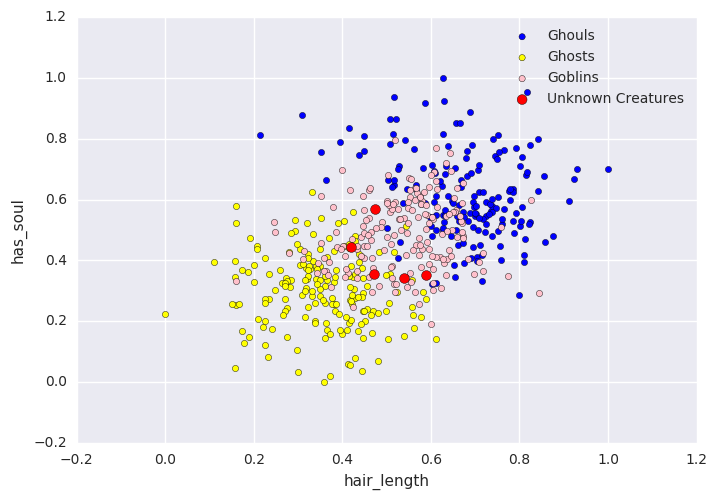

In [66]:
ax = test[test.type == 'Ghoul'].plot(kind='scatter',  x='hair_length', y='has_soul', color='Blue', label='Ghouls')
ax = test[test.type == 'Ghost'].plot(kind='scatter',  x='hair_length', y='has_soul', color='Yellow', label='Ghosts', ax=ax)
ax = test[test.type == 'Goblin'].plot(kind='scatter',  x='hair_length', y='has_soul', color='Pink', label='Goblins', ax=ax)

unknownDF.plot(kind='scatter', x='hair_length', y='has_soul', color='Red', s=50, label='Unknown Creatures', ax=ax);

The unknown creatures are in the middle, in the 'Goblins' zone. If we see the result dataset, we can see there is a tie and 'Goblins' are one of the alternatives, except for one of the items.

In [68]:
notAgreeDF

,RandomForrest,SVMLinear,DecisionTree,Neighbors,LinearModelSGD,GaussianNaiveBayes,GradientBoosting
3,Ghost,Ghost,Ghoul,Goblin,Goblin,Goblin,Ghoul
245,Goblin,Ghost,Ghost,Ghoul,Goblin,Goblin,Ghost
253,Ghoul,Ghoul,Goblin,Ghost,Goblin,Ghost,Ghoul
254,Ghoul,Ghoul,Ghost,Goblin,Goblin,Goblin,Ghoul
400,Goblin,Ghost,Ghoul,Ghost,Goblin,Ghost,Goblin


So, let's assume the 'Goblins' for the ones we have a tie, and assume 'Ghoul' for the one who is unknown.

In [82]:
test.ix[[3,245,253,245,400],'type'] = 'Goblin'
test.ix[254,'type'] = 'Ghoul'


## Output

Now we have the values, let's generate the output.

In [88]:
solution = pd.DataFrame({'id': test.id, 'type': test.type})
solution.to_csv('pandas_ghosts1.csv', index=0)

In [89]:
solution

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Goblin
4,13,Ghost
5,14,Ghost
6,15,Ghoul
7,16,Goblin
8,17,Goblin
9,18,Ghoul
